In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from math import ceil

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '1j1mbXJtpkwhgvc9Ydlp9tjlLzNeIVlOD'})
downloaded.GetContentFile('data_forecast.zip')

In [ ]:
!unzip data_forecast.zip

Archive:  data_forecast.zip
  inflating: alarms-daily-by-regions-240222-041124.csv  
  inflating: __MACOSX/._alarms-daily-by-regions-240222-041124.csv  
  inflating: alarms-daily-kyiv-240222-041124.csv  
  inflating: __MACOSX/._alarms-daily-kyiv-240222-041124.csv  
  inflating: events.csv              
  inflating: __MACOSX/._events.csv   
  inflating: exchange_rates.csv      
  inflating: __MACOSX/._exchange_rates.csv  
  inflating: fuel.csv                
  inflating: __MACOSX/._fuel.csv     
  inflating: sales.csv               
  inflating: __MACOSX/._sales.csv    
  inflating: shop_data.csv           
  inflating: __MACOSX/._shop_data.csv  


In [ ]:
rates = pd.read_csv('exchange_rates.csv')
rates['Date'] = pd.to_datetime(rates['Date'], format='%d.%m.%Y')
rates = rates.rename(columns={'Official hrivnya exchange rates, UAH':'rate'})
rates['rate'] = rates['rate'] / rates['Unit']
rates.head()

,Date,Time,Digital code,Letter code,Unit,Currency name,rate
0,2018-01-01,0.0,978,EUR,100,NaN,33.495424
1,2018-01-02,0.0,978,EUR,100,NaN,33.495424
2,2018-01-03,0.0,978,EUR,100,NaN,33.495424
3,2018-01-04,0.0,978,EUR,100,NaN,33.532796
4,2018-01-05,0.0,978,EUR,100,NaN,33.798126


In [ ]:
alarm_kyiv = pd.read_csv('alarms-daily-kyiv-240222-041124.csv', delimiter=';')
alarm_ukraine = pd.read_csv('alarms-daily-by-regions-240222-041124.csv', delimiter=';')
alarm_kyiv = alarm_kyiv.drop(columns=['reg_id', 'official_title_uk'])
alarm_ukraine = alarm_ukraine.drop(columns=['reg_id', 'official_title_uk'])
alarm_ukraine = alarm_ukraine.groupby('alarms_date').sum()
alarm_df = pd.merge(alarm_kyiv, alarm_ukraine, left_on='alarms_date', right_index=True)
alarm_df['alarms_quantity'] = alarm_df['alarms_quantity_x'] + alarm_df['alarms_quantity_y']
alarm_df = alarm_df.drop(columns=['alarms_quantity_x', 'alarms_quantity_y'])
alarm_df['alarms_date'] = pd.to_datetime(alarm_df['alarms_date'], format='%Y-%m-%d')
alarm_df = alarm_df.rename(columns={'alarms_date': 'Date'})
alarm_df.head()

,Date,alarms_quantity
0,2022-02-24,4
1,2022-02-25,22
2,2022-02-26,46
3,2022-02-27,65
4,2022-02-28,79


In [ ]:
fuel = pd.read_csv('fuel.csv', delimiter=';')
fuel['Diesel'] = fuel['Diesel'].str.replace(',', '.').astype(float)
fuel['Date'] = pd.to_datetime(fuel['Date'], format='%d.%m.%Y')
fuel.head()

,Date,Diesel
0,2019-01-02,29.10
1,2019-01-03,29.08
2,2019-01-04,29.04
3,2019-01-08,28.59
4,2019-01-09,28.57


In [ ]:
sales = pd.read_csv('sales.csv', delimiter=';')
sales_df = sales.loc[:, ~sales.columns.str.contains('^Unnamed')]
sales_df.loc[:, 'Sales'] = sales_df['Sales'].str.replace(' ', '').str.replace(',', '.').astype(float)
sales_df['Date'] = pd.to_datetime(sales_df['Date'], format='%d.%m.%Y')
sales_df = sales_df.sort_values(by='Date')
sales_df.tail()

<ipython-input-18-da481df19b79>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df['Date'] = pd.to_datetime(sales_df['Date'], format='%d.%m.%Y')


,Shop,Date,Sales
29396,2,2023-10-31,22721.47
29395,1,2023-10-31,19389.67
29423,29,2023-10-31,19343.99
29408,14,2023-10-31,21738.44
29424,30,2023-10-31,24290.96


In [ ]:
events = pd.read_csv('events.csv', delimiter=';')
events['Date_start'] = pd.to_datetime(events['Date_start'], format='%d.%m.%Y')
events['Date_end'] = pd.to_datetime(events['Date_end'], format='%d.%m.%Y')
events.head()

,Date_start,Date_end,Type,Event
0,2019-02-22,2019-02-23,Promotion,Promo1
1,2019-10-25,2019-10-25,Promotion,Halloween
2,2019-11-29,2019-12-01,Promotion,Black Friday
3,2020-02-21,2020-02-22,Promotion,Promo1
4,2020-03-16,2020-05-11,Lockdown,Hard lockdown


In [ ]:
shops_df = pd.read_csv('shop_data.csv', delimiter=';')
shops_df['City'] = shops_df['City'].str.extract('(\d+)').astype(int)
shops_df['Region'] = shops_df['Region'].str.extract('(\d+)').astype(int)
shops_df = shops_df.rename(columns={'Shop': 'shop_key'})
shops_df['Trade_area'] = shops_df['Trade_area'].str.replace(',', '.').astype(float)
shops_df['Open_date'] = pd.to_datetime(shops_df['Open_date'], format='%d.%m.%Y')
shops_df.head()

,shop_key,Open_date,Change_type,Trade_area,City,Region,City area,Local_reference,Floor
0,1,2018-10-04,NaN,36.04,15,1,sleeping quarters,bazaar,1
1,1,2021-12-20,Extension,48.05,15,1,sleeping quarters,bazaar,1
2,2,2018-01-12,NaN,30.93,8,2,periphery,supermarket,1
3,3,2018-02-16,NaN,36.94,27,3,centre,administrative institution,1
4,4,2018-01-22,NaN,17.42,7,4,sleeping quarters,supermarket,1


In [ ]:
def hbar(ddct, y_title, x_title):
  cat_vals = {k: len(v) for k, v in ddct.items()}
  categories = list(cat_vals.keys())
  values = list(cat_vals.values())

  plt.barh(categories, values)


  plt.xlabel(f'{x_title}')
  plt.ylabel(f'{y_title}')
  plt.title(f'{x_title} x {y_title}')

  plt.show()

In [ ]:
def plot_hists():
  city = dict()
  region = dict()
  city_area = dict()
  local_reference = dict()
  for i in range(shops_df.shape[0]):
    row = shops_df.iloc[i]
    if row['City'] not in city.keys():
      city[row['City']] = {row['shop_key']}
    else:
      city[row['City']].add(row['shop_key'])

    if row['Region'] not in region.keys():
      region[row['Region']] = {row['shop_key']}
    else:
      region[row['Region']].add(row['shop_key'])

    if row['City area'] not in city_area.keys():
      city_area[row['City area']] = {row['shop_key']}
    else:
      city_area[row['City area']].add(row['shop_key'])

    if row['Local_reference'] not in local_reference.keys():
      local_reference[row['Local_reference']] = {row['shop_key']}
    else:
      local_reference[row['Local_reference']].add(row['shop_key'])

  hbar(city, 'City', 'Store Count')
  hbar(region, 'Region', 'Store Count')
  hbar(city_area, 'City Area', 'Store Count')
  hbar(local_reference, 'Local Reference', 'Store Count')

In [ ]:
# plot_hists()

In [ ]:
# A few words about data

In [ ]:
# show how many stores are in different categories

In [ ]:
def rmse_manual(y_true, y_pred):
  mse = np.mean((y_pred - y_true) ** 2)
  return np.sqrt(mse)

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint

WINDOW_SIZE=30
def impute_missing(dfs):
  if type(dfs) is not dict:
    dfs = {'0': dfs}
  res = {}
  for k, df in dfs.items():
    rows_all_nan = df[df['Sales'].isna()==True]
    rows_all_nan = rows_all_nan.reset_index()

    # check if there are missing values
    if rows_all_nan.empty:
      res[k] = df
      continue

    # find the largest consecutive NaN group
    rows_all_nan['Consecutive_Group'] = (rows_all_nan['Date'].diff().dt.days != 1).cumsum()
    largest_group = rows_all_nan.groupby('Consecutive_Group').size().idxmax()
    largest_consecutive_series = rows_all_nan[rows_all_nan['Consecutive_Group'] == largest_group]
    # print('Largest missing values cluster is:', largest_consecutive_series.shape[0])
    # Get NaN group date range
    stop_date = largest_consecutive_series.iloc[0]['Date'] - pd.Timedelta(1)
    first_date = rows_all_nan[rows_all_nan['Date'] < stop_date]['Date'].max() + pd.Timedelta(1)
    if first_date is pd.NaT:
      first_date = df['Date'].min()
    # Get train dataframe
    df = df.reset_index()
    subset_between_dates = df[(df['Date'] >= first_date) & (df['Date'] <= stop_date)]

    # WINDOW_SIZE = largest_consecutive_series.shape[0]
    # Divide into Train Test
    test_df = subset_between_dates.copy()
    test_series = subset_between_dates[-largest_consecutive_series.shape[0]:]['Sales']
    test_df.iloc[-largest_consecutive_series.shape[0]:, test_df.columns.get_loc('Sales')] = np.nan

    # if the largest missing values group is so small, just don't care about backtesting
    if test_df.shape[0] < largest_consecutive_series.shape[0] + 10:
      rolling_mean = df['Sales'].rolling(window=WINDOW_SIZE, min_periods=1).mean()
      df['Sales'] = df['Sales'].fillna(rolling_mean).infer_objects(copy=False)
      res[k] = df
      continue

    # Choosing method
    rmse_compare = {}

    # Backward filling
    temp = test_df.copy().fillna(method='ffill')
    rmse_compare['backward'] = rmse_manual(test_series.values, temp[-largest_consecutive_series.shape[0]:].Sales.values)
    # Forward filling
    temp = test_df.copy().fillna(method='bfill')
    rmse_compare['forward'] = rmse_manual(test_series.values, temp[-largest_consecutive_series.shape[0]:].Sales.values)
    # Rolling Mean
    temp = subset_between_dates['Sales'].rolling(window=WINDOW_SIZE, center=True, min_periods=1).mean()
    rmse_compare['rolling_mean'] = rmse_manual(test_series.values, temp[-largest_consecutive_series.shape[0]:].values)

    # Rolling Median
    temp = subset_between_dates['Sales'].rolling(window=WINDOW_SIZE, center=True, min_periods=1).median()
    rmse_compare['rolling_median'] = rmse_manual(test_series.values, temp[-largest_consecutive_series.shape[0]:].values)

    # Multivariate imputation(Regularized Linear Regression)
    imputer = IterativeImputer()
    imputed_data = imputer.fit_transform(test_df['Sales'].values.reshape(-1, 1))
    rmse_compare['multivariate (Reg Lin Regr)'] = rmse_manual(test_series.values, imputed_data[-largest_consecutive_series.shape[0]:])

    # Multivariate imputation(Random Forest)
    imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10)
    imputed_data = imputer.fit_transform(test_df['Sales'].values.reshape(-1, 1))
    rmse_compare['multivariate (Random Forest)'] = rmse_manual(test_series.values, imputed_data[-largest_consecutive_series.shape[0]:])

    # Get lowest rmse
    min_key = min(rmse_compare, key=rmse_compare.get)
    min_value = rmse_compare[min_key]
    print(f'Best method for shop {int(k)} is {min_key} with RMSE: {min_value}')

    if 'mean' in min_key:
      while df['Sales'].isnull().any():
        df['Sales'] = df['Sales'].fillna(
          df['Sales'].rolling(window=WINDOW_SIZE, min_periods=1).mean()
        )

    if 'median' in min_key:
      while df['Sales'].isnull().any():
        df['Sales'] = df['Sales'].fillna(
          df['Sales'].rolling(window=WINDOW_SIZE, min_periods=1).median()
        )

    if 'Regr' in min_key:
      while df['Sales'].isnull().any():
        imputer = IterativeImputer()
        imputed_data = imputer.fit_transform(df[['Sales']])
        df['Sales'] = imputed_data.flatten()

    if 'Random' in min_key:
      while df['Sales'].isnull().any():
        imputer = IterativeImputer(
          estimator=RandomForestRegressor(), max_iter=10, random_state=0
        )
      imputed_data = imputer.fit_transform(df[['Sales']])
      df['Sales'] = imputed_data.flatten()

    if 'backward' in min_key:
      while df['Sales'].isnull().any():
        df['Sales'] = df['Sales'].fillna(method='bfill')

    if 'forward' in min_key:
      while df['Sales'].isnull().any():
        df['Sales'] = df['Sales'].fillna(method='ffill')

    res[k] = df
  return res

In [ ]:
from datetime import datetime, timedelta
# form events per specific store
def form_events(df):
  res = {}
  event_types = events['Type'].unique()
  for event_type in event_types:
    inter_res = []
    for index, row in events[events['Type']==event_type].iterrows():
      start_date = row['Date_start']
      end_date = row['Date_end']
      for day in range((end_date - start_date).days + 1):
        inter_res.append((start_date + timedelta(days=day)).strftime('%Y-%m-%d'))
    res[event_type] = inter_res
  nan_sales_dates = df[df['Sales'].isna()]['Date'].values
  res['Out Of Office'] = [
    pd.Timestamp(ddate).strftime('%Y-%m-%d') for ddate in df[df['Sales'].isna()]['Date'].values
]
  return res

In [ ]:
# construct dataset
def match_area_floor_lref(inter_df, shop_info):
  inter_df.loc[:, 'Area'] = 0.0
  inter_df.loc[:, 'Floor'] = 1
  inter_df.loc[:, 'Local_reference'] = ''
  inter_df.loc[:, 'City area'] = ''
  shop_info = shop_info.reset_index(drop=True)
  if shop_info.shape[0] > 1:
      pivot_date = shop_info.loc[1, 'Open_date']
      inter_df.loc[inter_df['Date'] >= pivot_date, 'Area'] = shop_info.loc[1, 'Trade_area']
      inter_df.loc[inter_df['Date'] < pivot_date, 'Area'] = shop_info.loc[0, 'Trade_area']
      inter_df.loc[inter_df['Date'] >= pivot_date, 'Floor'] = shop_info.loc[1, 'Floor']
      inter_df.loc[inter_df['Date'] < pivot_date, 'Floor'] = shop_info.loc[0, 'Floor']
      inter_df.loc[inter_df['Date'] >= pivot_date, 'Local_reference'] = shop_info.loc[1, 'Local_reference']
      inter_df.loc[inter_df['Date'] < pivot_date, 'Local_reference'] = shop_info.loc[0, 'Local_reference']
      inter_df.loc[inter_df['Date'] >= pivot_date, 'City area'] = shop_info.loc[1, 'City area']
      inter_df.loc[inter_df['Date'] < pivot_date, 'City area'] = shop_info.loc[0, 'City area']
  else:
      inter_df.loc[:, 'Area'] = shop_info['Trade_area'].iloc[0]
      inter_df.loc[:, 'Floor'] = shop_info['Floor'].iloc[0]
      inter_df.loc[:, 'Local_reference'] = shop_info['Local_reference'].iloc[0]
      inter_df.loc[:, 'City area'] = shop_info['City area'].iloc[0]
  return inter_df

def add_currency(inter_df):
  inter_df = pd.merge(
      inter_df,
      rates[rates['Letter code']=='EUR'][['Date', 'rate']],
      on='Date',
      how='left')
  inter_df = inter_df.rename(columns={'rate':'EUR'})
  inter_df['EUR'] = round(inter_df['EUR'],2)
  inter_df = pd.merge(
      inter_df,
      rates[rates['Letter code']=='USD'][['Date', 'rate']],
      on='Date',
      how='left')
  inter_df = inter_df.rename(columns={'rate':'USD'})
  inter_df['EUR'] = round(inter_df['USD'],2)
  return inter_df

def add_alerts(inter_df):
  inter_df = pd.merge(
      inter_df,
      alarm_df,
      on='Date',
      how='left')
  inter_df['alarms_quantity'] = inter_df['alarms_quantity'].fillna(0)
  inter_df['alarms_quantity'] = inter_df['alarms_quantity'].astype(int)
  inter_df = inter_df.sort_values(by='Date')
  return inter_df

SALES_LAGS = [1, 7]
def get_filtered_df(shop=None,
                    city=None,
                    region=None,
                    city_area=None,
                    local_reference=None,
                    floor=None,
                    fill_zero=False):
  """
  Provide detailed filters to plot data. Filters are:
  shops as list of shop numbers ex. [1, 2, 3]
  city as list of city numbers ex. [1, 2, 3]
  region as list of region numbers ex. [1, 2, 3]
  city_area as list of city area ex. [center]
  local_reference as list of local_reference ex. [bazaar]
  floor as list of floor ex. [1]

  As a result, the dict of values will be returned were keys are shop numbers
  and values are datasets. The datasets contain full data
  """

  if shop is None:
      shop = shops_df['shop_key'].unique().tolist()
  if city is None:
      city = shops_df['City'].unique().tolist()
  if region is None:
      region = shops_df['Region'].unique().tolist()
  if city_area is None:
      city_area = shops_df['City area'].unique().tolist()
  if local_reference is None:
      local_reference = shops_df['Local_reference'].unique().tolist()
  if floor is None:
      floor = shops_df['Floor'].unique().tolist()

  if (not set(shop).issubset(shops_df['shop_key'].unique())) or \
      (not set(city).issubset(shops_df['City'].unique())) or \
      (not set(region).issubset(shops_df['Region'].unique())) or \
      (not set(city_area).issubset(shops_df['City area'].unique())) or \
      (not set(local_reference).issubset(shops_df['Local_reference'].unique())) or \
      (not set(floor).issubset(shops_df['Floor'].unique())):
      return 'Check your input'

  res_dfs = []


  # filters = {
  #       'shop_key': shop or shops_df['shop_key'].unique().tolist(),
  #       'City': city or shops_df['City'].unique().tolist(),
  #       'Region': region or shops_df['Region'].unique().tolist(),
  #       'City area': city_area or shops_df['City area'].unique().tolist(),
  #       'Local_reference': local_reference or shops_df['Local_reference'].unique().tolist(),
  #       'Floor': floor or shops_df['Floor'].unique().tolist()
  #   }

  # # Validate inputs
  # for column, values in filters.items():
  #     if not set(values).issubset(shops_df[column].unique()):
  #         raise ValueError(f"Invalid values in {column}: {set(values) - set(shops_df[column].unique())}")

  # # Apply filters
  # filtered_df = shops_df.copy()
  # for column, values in filters.items():
  #     filtered_df = filtered_df[filtered_df[column].isin(values)]

  # filtered_df = shops_df[
  #     (shops_df['shop_key'].isin(shop)) &
  #     (shops_df['City'].isin(city)) &
  #     (shops_df['Region'].isin(region)) &
  #     (shops_df['City area'].isin(city_area)) &
  #     (shops_df['Local_reference'].isin(local_reference)) &
  #     (shops_df['Floor'].isin(floor))
  # ]

  filtering_dct = {
      'shop_key': shop,
      'City': city,
      'Region': region,
      'City area': city_area,
      'Local_reference': local_reference,
      'Floor': floor
  }

  filtered_df = shops_df.copy()
  for key, var in filtering_dct.items():
    filtered_df = filtered_df[filtered_df[key].isin(var)]

  filtered_df = filtered_df.drop_duplicates(subset='shop_key')

  filtered_df = filtered_df[['shop_key', 'City', 'Region', 'City area', 'Local_reference', 'Floor']]

  merged_df = pd.merge(sales_df, filtered_df, left_on='Shop', right_on='shop_key', how='inner')
  merged_df.drop(columns=['shop_key'], inplace=True)

  merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%d.%m.%Y')
  shops = merged_df['Shop'].unique().tolist()
  print('Shops in such category:', *shops)
  for i in range(len(shops)):
    shop_num = int(shops[i])
    inter_df = merged_df[merged_df['Shop'] == shop_num].copy()
    shop_info = shops_df[shops_df['shop_key'] == shop_num]
    inter_df = inter_df.set_index('Date').asfreq('D')
    inter_df = inter_df.reset_index().rename(columns={'index': 'Date'})

    # ensure Area and Floor changes
    inter_df = match_area_floor_lref(inter_df, shop_info)

    # Add fuel data
    inter_df = pd.merge(inter_df, fuel, on='Date', how='left')
    # Add exchange rates data
    inter_df = add_currency(inter_df)
    # Add air alerts data
    inter_df = add_alerts(inter_df)
    # Add lagged values
    for lag in SALES_LAGS:
      inter_df['Sales_{0}'.format(lag)] = inter_df['Sales'].shift(lag)
    # Add information related to date
    inter_df['day'] = inter_df['Date'].dt.day
    inter_df['week'] = inter_df['Date'].dt.isocalendar().week
    inter_df['year'] = inter_df['Date'].dt.year

    inter_df = inter_df.set_index('Date')
    inter_df = inter_df.asfreq('D')
    inter_df = inter_df.reset_index()

    # Filling zeros
    if fill_zero:
      # inter_df.loc[:, 'Sales'] = inter_df.loc[:, 'Sales'].infer_objects().interpolate(limit=2, method='linear')
      inter_df = impute_missing(inter_df)['0']
      inter_df['Sales'] = inter_df['Sales'].fillna(method='ffill')
      inter_df['Sales'] = inter_df['Sales'].fillna(method='bfill')

    # Ensuring missing categories
    for col in inter_df.columns:
      if col != 'Sales':
          inter_df[col] = inter_df[col].fillna(method='ffill')
          inter_df[col] = inter_df[col].fillna(method='bfill')

    for key, var in filtering_dct.items():
      if key == 'shop_key':
        key = 'Shop'
      inter_df = inter_df[inter_df[key].isin(var)]

    events = form_events(inter_df)
    res_dfs.append((inter_df, events))
  return dict(zip(shops, res_dfs))

In [ ]:
def dataset_divider(df):
  res = []
  if len(df['Local_reference'].unique()) > 1:
    for ref in df['Local_reference'].unique():
      res.append(df[df['Local_reference']==ref])
  if len(df['City area'].unique()) > 1:
    for area in df['City area'].unique():
      res.append(df[df['City area']==area])
  if len(res) < 2:
    return res[0]
  return res

In [ ]:
data = get_filtered_df(shop=[18], fill_zero=True)

Shops in such category: 18
Best method for shop 0 is rolling_mean with RMSE: 7476.735169669897


<ipython-input-27-df8ff42dca6d>:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp = test_df.copy().fillna(method='ffill')
<ipython-input-27-df8ff42dca6d>:51: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = test_df.copy().fillna(method='ffill')
<ipython-input-27-df8ff42dca6d>:54: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp = test_df.copy().fillna(method='bfill')
<ipython-input-27-df8ff42dca6d>:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-

In [ ]:
from pprint import pprint
pprint(data[18][0].isnull().any().any())

False


In [ ]:
# !pip install fancyimpute

In [ ]:
# data_to_work_with = impute_missing(get_filtered_df(city_area=['sleeping quarters'],
#                                                    local_reference=['bazaar']))

In [ ]:
# plot ts
def plot_filtered_ts(shop=None,
                    city=None,
                    region=None,
                    city_area=None,
                    local_reference=None,
                    floor=None,
                    daily=False,
                    weekly=False,
                    monthly=False,
                    fill_zero=False,
                    WINDOW_SIZE=30):
  """
  Provide detailed filters to plot data. Filters are:
  shops as list of shop numbers ex. [1, 2, 3]
  city as list of city numbers ex. [1, 2, 3]
  region as list of region numbers ex. [1, 2, 3]
  city_area as list of city area ex. [center]
  local_reference as list of local_reference ex. [bazaar]
  floor as list of floor ex. [1]

  There is also possibility to choose period for ts like daily, weekly, monthly
  by providing Bool values as an appropriate argument

  As a result, the plots on daily, weekly, yearly data will be provided as output
  for each shop in this group
  """
  dfs = get_filtered_df(shop, city, region, city_area, local_reference, floor, fill_zero)

  for shop_index, df in dfs.items():
    df_to_use = df[0].copy()
    df_to_use = df_to_use[['Date', 'Sales']]

    if daily:
      # Daily Data

      df_to_use.plot(x='Date', y='Sales')
      plt.xlabel('Day')
      plt.ylabel('Total Sales')
      plt.title(f'Total Sales by Day SHOP{shop_index}')
      plt.xticks(rotation=45)
      plt.tight_layout()

      plt.show()

    if weekly:
      # Weekly data

      weekly_sales = df.groupby(pd.Grouper(key='Date', freq='1W'))['Sales'].sum()
      weekly_sales.plot(x='Date', y='Sales')

      plt.xlabel('Week')
      plt.ylabel('Total Sales')
      plt.title(f'Total Weekly Sales SHOP{shop_index}')
      plt.xticks(rotation=45)
      plt.tight_layout()

      plt.show()

    if monthly:
      # Monthly data

      monthly_sales = df.groupby(pd.Grouper(key='Date', freq='1M'))['Sales'].sum()
      monthly_sales.plot(x='Date', y='Sales')

      plt.xlabel('Month')
      plt.ylabel('Total Sales')
      plt.title(f'Total Monthly Sales SHOP{shop_index}')
      plt.xticks(rotation=45)
      plt.tight_layout()

      plt.show()


Shops in such category: 20


<ipython-input-27-df8ff42dca6d>:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp = test_df.copy().fillna(method='ffill')
<ipython-input-27-df8ff42dca6d>:51: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = test_df.copy().fillna(method='ffill')
<ipython-input-27-df8ff42dca6d>:54: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp = test_df.copy().fillna(method='bfill')
<ipython-input-27-df8ff42dca6d>:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-

Best method for shop 0 is backward with RMSE: 45.340000000000146


<ipython-input-29-2a61fb12d71d>:187: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  inter_df[col] = inter_df[col].fillna(method='ffill')


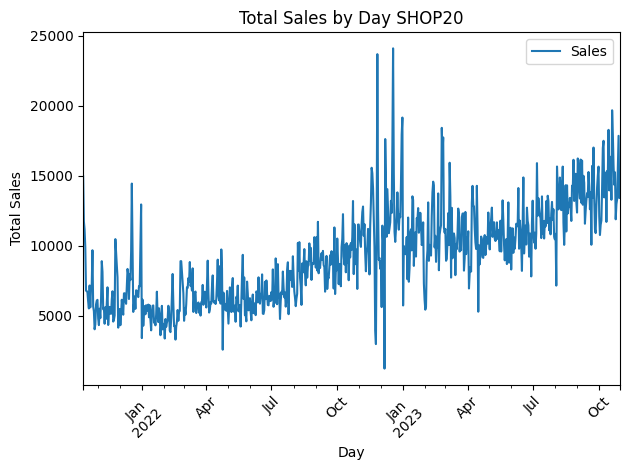

Shops in such category: 21
Best method for shop 0 is backward with RMSE: 1970.869999999999


<ipython-input-27-df8ff42dca6d>:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp = test_df.copy().fillna(method='ffill')
<ipython-input-27-df8ff42dca6d>:51: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = test_df.copy().fillna(method='ffill')
<ipython-input-27-df8ff42dca6d>:54: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp = test_df.copy().fillna(method='bfill')
<ipython-input-27-df8ff42dca6d>:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-

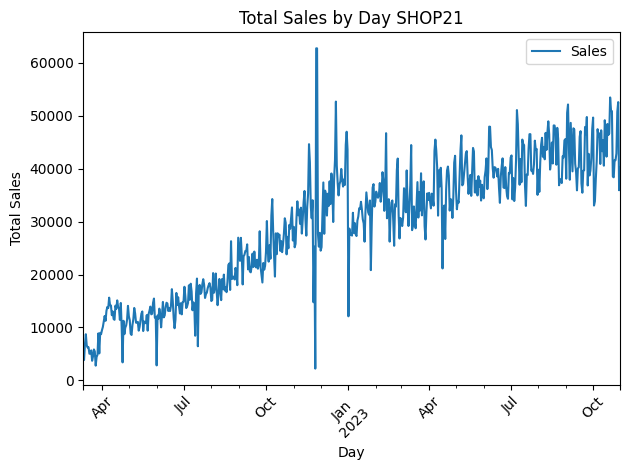

Shops in such category: 22


<ipython-input-29-2a61fb12d71d>:181: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  inter_df['Sales'] = inter_df['Sales'].fillna(method='ffill')
<ipython-input-29-2a61fb12d71d>:181: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  inter_df['Sales'] = inter_df['Sales'].fillna(method='ffill')
<ipython-input-29-2a61fb12d71d>:182: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  inter_df['Sales'] = inter_df['Sales'].fillna(method='bfill')
<ipython-input-29-2a61fb12d71d>:187: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


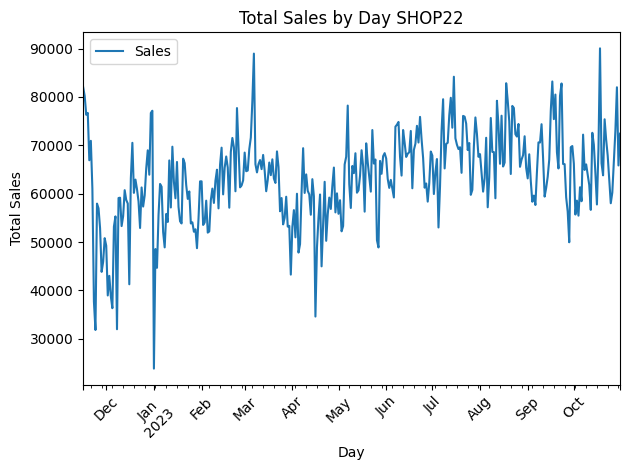

Shops in such category: 23
Best method for shop 0 is rolling_median with RMSE: 219.0550000000003


<ipython-input-27-df8ff42dca6d>:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp = test_df.copy().fillna(method='ffill')
<ipython-input-27-df8ff42dca6d>:51: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = test_df.copy().fillna(method='ffill')
<ipython-input-27-df8ff42dca6d>:54: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp = test_df.copy().fillna(method='bfill')
<ipython-input-27-df8ff42dca6d>:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-

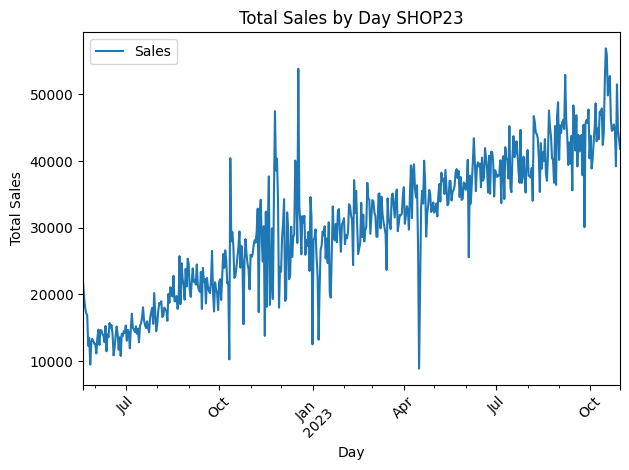

Shops in such category: 24
Best method for shop 0 is backward with RMSE: 1420.9599999999991


<ipython-input-27-df8ff42dca6d>:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp = test_df.copy().fillna(method='ffill')
<ipython-input-27-df8ff42dca6d>:51: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = test_df.copy().fillna(method='ffill')
<ipython-input-27-df8ff42dca6d>:54: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp = test_df.copy().fillna(method='bfill')
<ipython-input-27-df8ff42dca6d>:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-

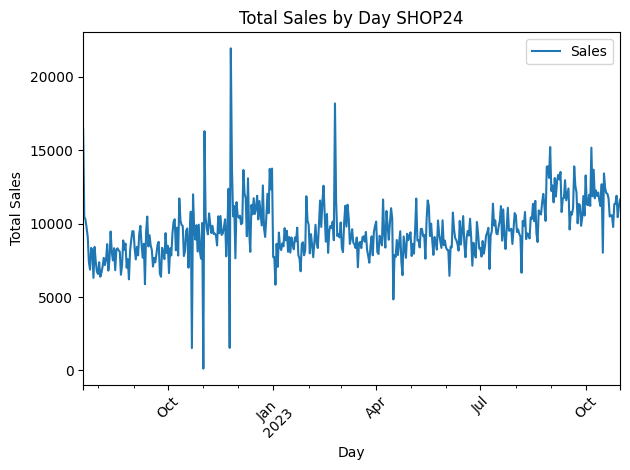

Shops in such category: 25


<ipython-input-29-2a61fb12d71d>:181: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  inter_df['Sales'] = inter_df['Sales'].fillna(method='ffill')
<ipython-input-29-2a61fb12d71d>:181: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  inter_df['Sales'] = inter_df['Sales'].fillna(method='ffill')
<ipython-input-29-2a61fb12d71d>:182: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  inter_df['Sales'] = inter_df['Sales'].fillna(method='bfill')
<ipython-input-29-2a61fb12d71d>:187: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


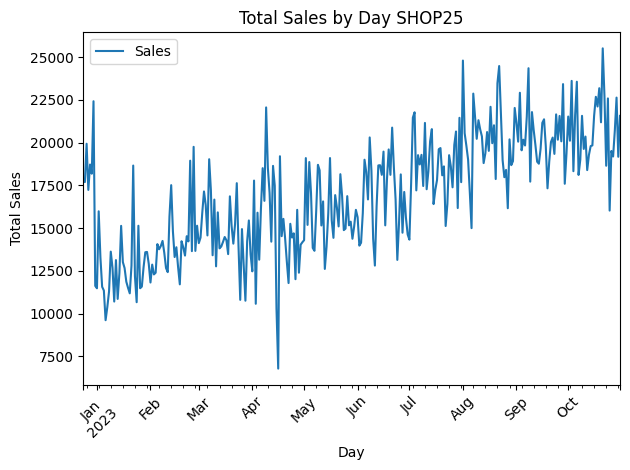

Shops in such category: 26
Best method for shop 0 is rolling_mean with RMSE: 1821.8647598736836


<ipython-input-27-df8ff42dca6d>:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp = test_df.copy().fillna(method='ffill')
<ipython-input-27-df8ff42dca6d>:51: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = test_df.copy().fillna(method='ffill')
<ipython-input-27-df8ff42dca6d>:54: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp = test_df.copy().fillna(method='bfill')
<ipython-input-27-df8ff42dca6d>:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-

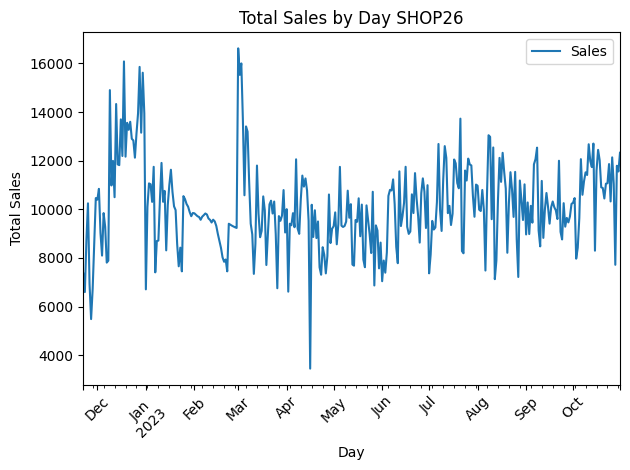

Shops in such category: 27


<ipython-input-29-2a61fb12d71d>:181: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  inter_df['Sales'] = inter_df['Sales'].fillna(method='ffill')
<ipython-input-29-2a61fb12d71d>:181: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  inter_df['Sales'] = inter_df['Sales'].fillna(method='ffill')
<ipython-input-29-2a61fb12d71d>:182: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  inter_df['Sales'] = inter_df['Sales'].fillna(method='bfill')
<ipython-input-29-2a61fb12d71d>:187: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


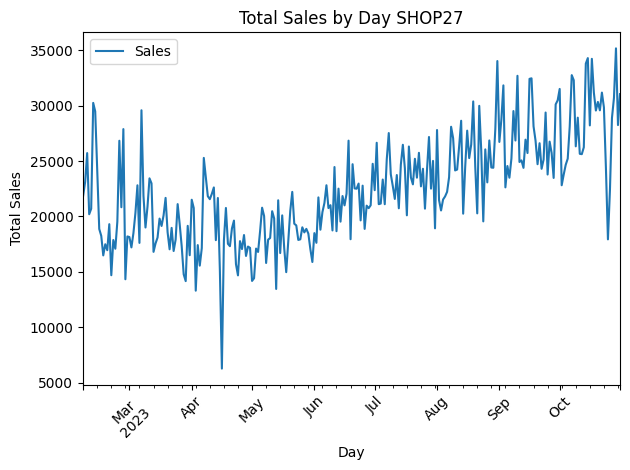

Shops in such category: 28


<ipython-input-29-2a61fb12d71d>:181: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  inter_df['Sales'] = inter_df['Sales'].fillna(method='ffill')
<ipython-input-29-2a61fb12d71d>:181: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  inter_df['Sales'] = inter_df['Sales'].fillna(method='ffill')
<ipython-input-29-2a61fb12d71d>:182: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  inter_df['Sales'] = inter_df['Sales'].fillna(method='bfill')
<ipython-input-29-2a61fb12d71d>:187: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


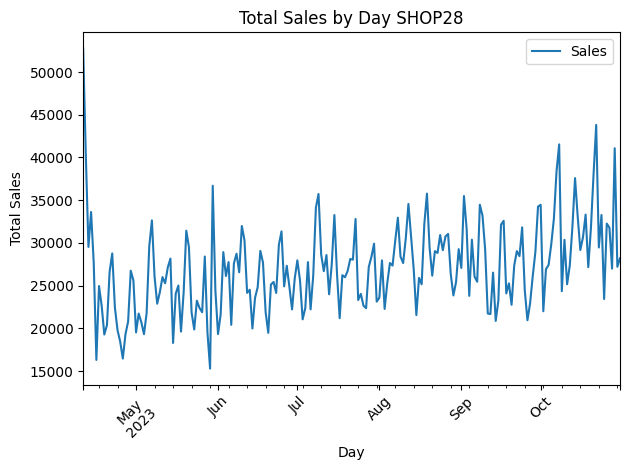

Shops in such category: 29


<ipython-input-29-2a61fb12d71d>:181: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  inter_df['Sales'] = inter_df['Sales'].fillna(method='ffill')
<ipython-input-29-2a61fb12d71d>:181: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  inter_df['Sales'] = inter_df['Sales'].fillna(method='ffill')
<ipython-input-29-2a61fb12d71d>:182: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  inter_df['Sales'] = inter_df['Sales'].fillna(method='bfill')
<ipython-input-29-2a61fb12d71d>:187: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


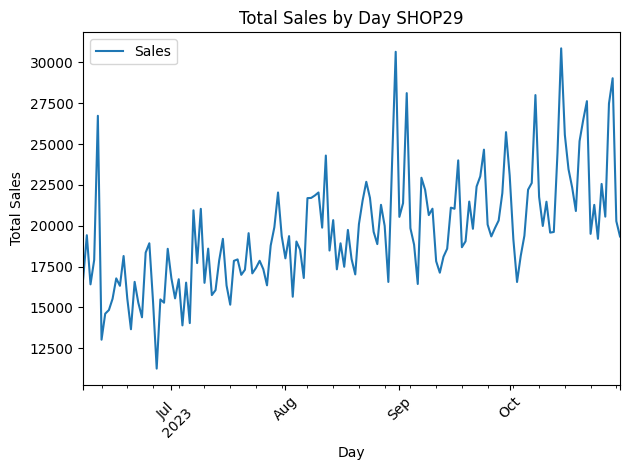

Shops in such category: 30


<ipython-input-29-2a61fb12d71d>:181: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  inter_df['Sales'] = inter_df['Sales'].fillna(method='ffill')
<ipython-input-29-2a61fb12d71d>:181: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  inter_df['Sales'] = inter_df['Sales'].fillna(method='ffill')
<ipython-input-29-2a61fb12d71d>:182: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  inter_df['Sales'] = inter_df['Sales'].fillna(method='bfill')
<ipython-input-29-2a61fb12d71d>:187: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


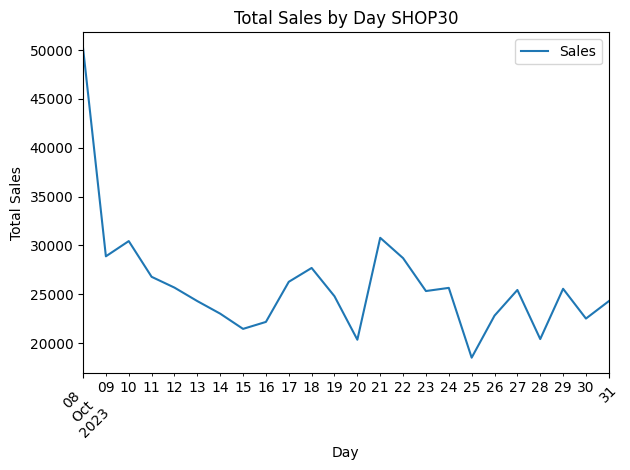

In [ ]:
for i in range(20, len(sales['Shop'].unique()) + 1):
  plot_filtered_ts(shop=[i], daily=True, fill_zero=True)

In [ ]:
# Plot predictions
def plotter_prediction(real_series, pred):
  time = [i for i in range(len(real_series) + len(pred))]
  plt.plot(x=time[:len(real_series)], y=real_series, label='Actual Data', color='blue')
  plt.plot(x=time[len(real_series):], y=pred, label='Predicted', color='red')
  plt.show()

In [ ]:
FORECASTING_STEP = 30
def k_fold(n_splits, df, y_var, x_vars, model_cls, **kwargs):
  # check if such split is possible
  n_samples = df.shape[0]
  if n_samples - FORECASTING_STEP * n_splits < 365:
    return f'Max possible split number is {int((n_samples - 365) % 30)}'
  temp_df = df.copy()
  # Reserve data for test set
  test = temp_df[-FORECASTING_STEP:]
  train_test = temp_df[:-FORECASTING_STEP]
  temp_df = temp_df[:-FORECASTING_STEP]

  train_test_indices = []
  # build datasets
  for i in range(2, n_splits):
    train_test_indices.append((-FORECASTING_STEP * i, -FORECASTING_STEP * (i - 1)))
    # train_sets.append(temp_df[:-FORECASTING_STEP * i])
    # test_sets.append(-FORECASTING_STEP * i:-FORECASTING_STEP * (i - 1))

  # Perform train-validation
  validation_rmse = []
  for fold, indices in enumerate(tqdm(train_test_indices, desc="K-Fold Progress")):
    train_df = temp_df[:indices[0]]
    test_df = temp_df[indices[0]:indices[1]]

    model = model_cls(**kwargs)
    model.fit(train_df[x_vars], train_df[y_var])
    preds = model.predict(test_df[x_vars])
    validation_rmse.append(rmse(test_df[y_var]), preds)

    print(f"Fold {fold + 1} completed")

  # Perform test
  model = model_cls(**kwargs)
  model.fit(train_test[x_vars], train_test[y_var])
  preds = model.predict(test[x_vars])

  mean_validation_rmse = np.mean(validation_rmse)
  test_rmse = rmse(test[y_var], preds)

  # Plot results
  print('Mean RMSE on validation:', mean_validation_rmse)
  print('RMSE on test:', test_rmse)
  plotter_prediction(test[y_var], preds)

  # # Do train validation until train set has less samples than 365
  # mult = 2
  # while True:
  #   if n_samples - FORECASTING_STEP * mult:
  #     break

  #   train_df = temp_df[:-FORECASTING_STEP * mult]
  #   test_df = temp_df[-FORECASTING_STEP * mult:-FORECASTING_STEP * (mult - 1)]

  #   model = model_cls(**kwargs)
  #   model.fit(train_df[x_vars], train_df[y_var])
  #   preds = model.predict(test_df[x_vars])
  #   validation_rmse.append(rmse(test_df[y_var]), preds)

  #   mult+= 1

In [ ]:
FORECASTING_STEP = 30
def k_fold_global(n_splits, y_var, x_vars, model_cls, model_params: dict, *dfs):
  # check if such split is possible
  n_samples = min([df.shape[0] for df in dfs])
  if n_samples - FORECASTING_STEP * n_splits < 365:
    return f'Max possible split number is {int((n_samples - 365) % 30)}'
  # Reserve data for test set
  test = [df[-FORECASTING_STEP:] for df in dfs]
  train_test = [df[:-FORECASTING_STEP] for df in dfs]

  temp_df = [df[:-FORECASTING_STEP] for df in dfs]

  train_test_indices = []
  # build datasets
  for i in range(2, n_splits):
    train_test_indices.append((-FORECASTING_STEP * i, -FORECASTING_STEP * (i - 1)))
    # train_sets.append(temp_df[:-FORECASTING_STEP * i])
    # test_sets.append(-FORECASTING_STEP * i:-FORECASTING_STEP * (i - 1))

  # Perform train-validation
  validation_rmse = []
  for fold, indices in enumerate(tqdm(train_test_indices, desc="K-Fold Progress")):
    train_df = [df[:indices[0]] for df in temp_df]
    test_df = [df[indices[0]:indices[1]] for df in temp_df]

    model = model_cls(**model_params)
    model.fit(train_df[x_vars], train_df[y_var])
    preds = model.predict(test_df[x_vars])
    validation_rmse.append(rmse(test_df[y_var]), preds)

    print(f"Fold {fold + 1} completed")

  # Perform test
  model = model_cls(**model_params)
  model.fit(train_test[x_vars], train_test[y_var])
  preds = model.predict(test[x_vars])

  mean_validation_rmse = np.mean(validation_rmse)
  test_rmse = rmse(test[y_var], preds)

  # Plot results
  print('Mean RMSE on validation:', mean_validation_rmse)
  print('RMSE on test:', test_rmse)
  plotter_prediction(test[y_var], preds)

  # # Do train validation until train set has less samples than 365
  # mult = 2
  # while True:
  #   if n_samples - FORECASTING_STEP * mult:
  #     break

  #   train_df = temp_df[:-FORECASTING_STEP * mult]
  #   test_df = temp_df[-FORECASTING_STEP * mult:-FORECASTING_STEP * (mult - 1)]

  #   model = model_cls(**kwargs)
  #   model.fit(train_df[x_vars], train_df[y_var])
  #   preds = model.predict(test_df[x_vars])
  #   validation_rmse.append(rmse(test_df[y_var]), preds)

  #   mult+= 1

In [ ]:
res = get_filtered_df(shop=[18], fill_zero=True)
df = res[18][0]
df

Shops in such category: 18
Best method for shop 0 is rolling_mean with RMSE: 7476.735169669897


<ipython-input-27-df8ff42dca6d>:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp = test_df.copy().fillna(method='ffill')
<ipython-input-27-df8ff42dca6d>:51: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = test_df.copy().fillna(method='ffill')
<ipython-input-27-df8ff42dca6d>:54: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp = test_df.copy().fillna(method='bfill')
<ipython-input-27-df8ff42dca6d>:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-

,index,Date,Shop,Sales,City,Region,City area,Local_reference,Floor,Area,Diesel,EUR,USD,alarms_quantity,Sales_1,Sales_7,day,week,year
0,0,2021-05-24,18.0,5218.92,14.0,13.0,sleeping quarters,bazaar,1.0,45.95,27.35,27.46,27.4572,0,5218.92,5218.92,24,21,2021
1,1,2021-05-25,18.0,5964.11,14.0,13.0,sleeping quarters,bazaar,1.0,45.95,27.35,27.43,27.4281,0,5218.92,5218.92,25,21,2021
2,2,2021-05-26,18.0,4206.46,14.0,13.0,sleeping quarters,bazaar,1.0,45.95,27.33,27.46,27.4553,0,5964.11,5218.92,26,21,2021
3,3,2021-05-27,18.0,4833.18,14.0,13.0,sleeping quarters,bazaar,1.0,45.95,27.35,27.55,27.5461,0,4206.46,5218.92,27,21,2021
4,4,2021-05-28,18.0,3942.94,14.0,13.0,sleeping quarters,bazaar,1.0,45.95,27.34,27.53,27.5260,0,4833.18,5218.92,28,21,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,886,2023-10-27,18.0,68384.05,14.0,13.0,centre,bazaar,2.0,61.26,55.67,36.51,36.5082,34,66508.71,72847.00,27,43,2023
887,887,2023-10-28,18.0,82875.86,14.0,13.0,centre,bazaar,2.0,61.26,55.67,36.51,36.5082,67,68384.05,88792.37,28,43,2023
888,888,2023-10-29,18.0,79778.86,14.0,13.0,centre,bazaar,2.0,61.26,55.67,36.51,36.5082,72,82875.86,82691.74,29,43,2023
889,889,2023-10-30,18.0,59995.35,14.0,13.0,centre,bazaar,2.0,61.26,55.69,36.42,36.4216,63,79778.86,59055.59,30,44,2023


In [ ]:
df.columns

Index(['index', 'Date', 'Shop', 'Sales', 'City', 'Region', 'City area',
       'Local_reference', 'Floor', 'Area', 'Diesel', 'EUR', 'USD',
       'alarms_quantity', 'Sales_1', 'Sales_7', 'day', 'week', 'year'],
      dtype='object')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
features = [
    'Diesel', 'EUR', 'USD', 'alarms_quantity',
    'day', 'week', 'year',
    'Sales_1', 'Sales_7'
]

target = 'Sales'

### Split the data

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)
train_data, val_data = train_test_split(train_data, test_size=0.2, shuffle=False)
train_data = train_data.dropna()

X_train, y_train = train_data[features], train_data[target]
X_val, y_val = val_data[features], val_data[target]
X_test, y_test = test_data[features], test_data[target]

### Linear regression

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

def k_fold_cross_validation(df, features, target, model, n_splits=5, shuffle=False):
    kf = KFold(n_splits=n_splits, shuffle=shuffle)
    mape_scores = []

    for train_index, test_index in kf.split(df):
        train_data_fold = df.iloc[train_index]
        test_data_fold = df.iloc[test_index]

        X_train_fold, y_train_fold = train_data_fold[features], train_data_fold[target]
        X_test_fold, y_test_fold = test_data_fold[features], test_data_fold[target]

        model.fit(X_train_fold, y_train_fold)

        y_pred_fold = model.predict(X_test_fold)

        mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold) * 100
        mape_scores.append(mape_fold)

    average_mape = np.mean(mape_scores)
    return average_mape

In [ ]:
lr = LinearRegression()
average_mape_lr = k_fold_cross_validation(df, features, target, lr, n_splits=5)
print(f"LR K-fold MAPE: {average_mape_lr}%")

LR K-fold MAPE: 20.993612633718893%


In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)

In [ ]:
last_month_test_data = test_data.iloc[-30:]

In [ ]:
y_pred_last_month_lr = lr.predict(last_month_test_data[features])
y_pred_last_month_lr_try = y_pred_last_month_lr

mape_lr = mean_absolute_percentage_error(last_month_test_data[target], y_pred_last_month_lr_try) * 100
print(f"MAPE LR: {mape_lr}%")

MAPE LR: 12.643759428187845%


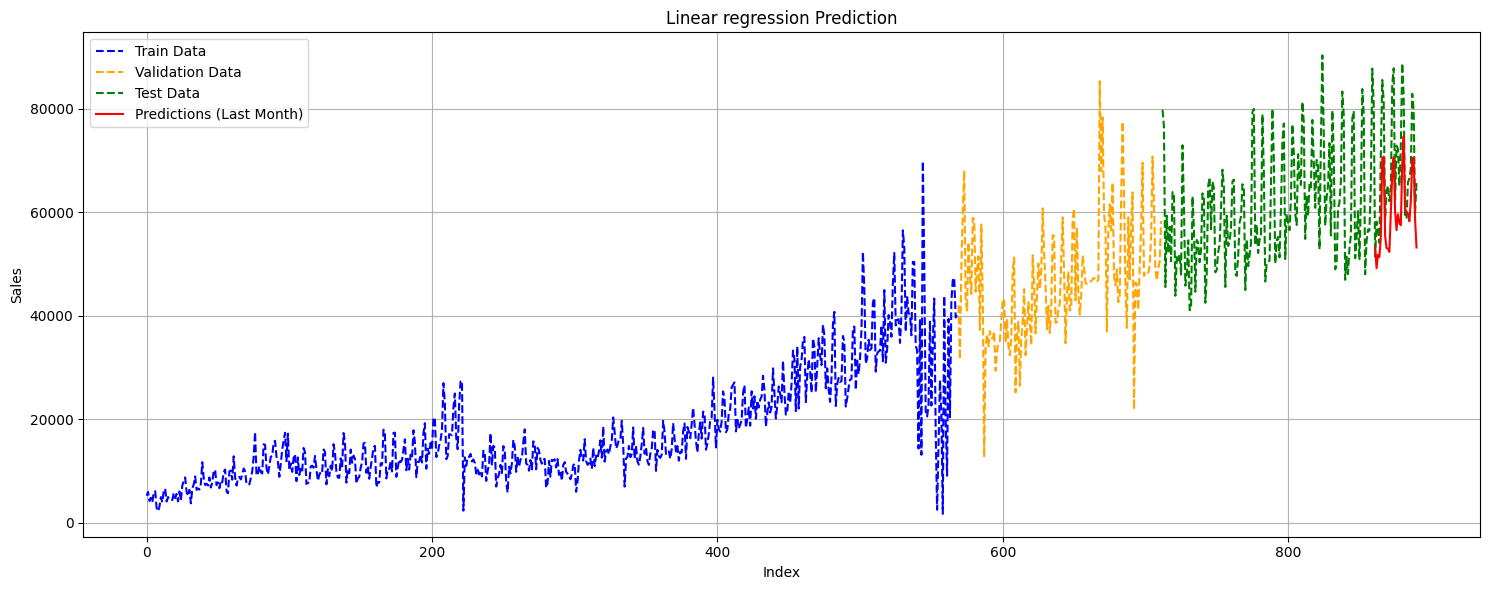

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, y_train, color='blue', label='Train Data', linestyle='--')
plt.plot(val_data.index, y_val, color='orange', label='Validation Data', linestyle='--')
plt.plot(test_data.index, y_test, color='green', label='Test Data', linestyle='--')
plt.plot(last_month_test_data.index, y_pred_last_month_lr_try, color='red', label='Predictions (Last Month)')
plt.title('Linear regression Prediction')
plt.xlabel('Index')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
rf = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10, min_samples_split=10)
average_mape_rf = k_fold_cross_validation(df, features, target, rf, n_splits=5)
print(f"RF K-fold MAPE: {average_mape_rf}%")

RF K-fold MAPE: 30.042773746620707%


In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_absolute_percentage_error
# param_grid = {
#     'n_estimators': [500, 1000, 1500],
#     'max_depth': [2, 5, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# rf = RandomForestRegressor(random_state=42)
# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     scoring='neg_mean_absolute_error',
#     cv=3,
#     verbose=2,
#     n_jobs=-1
# )

# grid_search.fit(X_train, y_train)
# print("Best Parameters:", grid_search.best_params_)


# result -> Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}

In [ ]:
rf = RandomForestRegressor(random_state=42, n_estimators=500, max_depth=5, min_samples_split=10, min_samples_leaf=2)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

In [ ]:
last_month_test_data = test_data.iloc[-30:]

y_pred_last_month_rf = rf.predict(last_month_test_data[features])

y_pred_last_month_rf_try = y_pred_last_month_rf

mape_rf = mean_absolute_percentage_error(last_month_test_data[target], y_pred_last_month_rf_try) * 100
print(f"MAPE PF: {mape_rf}%")

MAPE PF: 27.24812986208564%


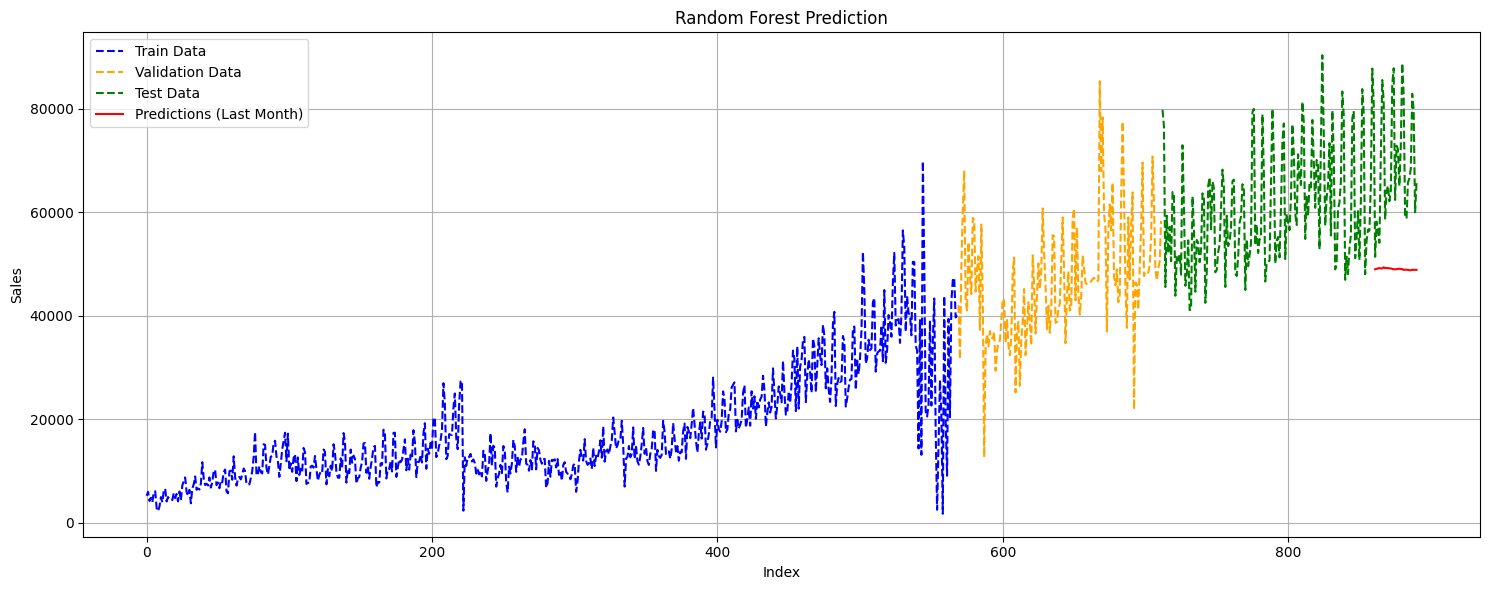

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, y_train, color='blue', label='Train Data', linestyle='--')
plt.plot(val_data.index, y_val, color='orange', label='Validation Data', linestyle='--')
plt.plot(test_data.index, y_test, color='green', label='Test Data', linestyle='--')
plt.plot(last_month_test_data.index, y_pred_last_month_rf_try, color='red', label='Predictions (Last Month)')
plt.title('Random Forest Prediction')
plt.xlabel('Index')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
y_pred_last_month_rf_try = y_pred_last_month_rf
y_pred_last_month_combined = y_pred_last_month_rf_try + y_pred_last_month_lr_try
mape_combined = mean_absolute_percentage_error(last_month_test_data[target], y_pred_last_month_combined) * 100
print(f"RF+LR: {mape_combined}%")

RF+LR: 60.65320407289009%


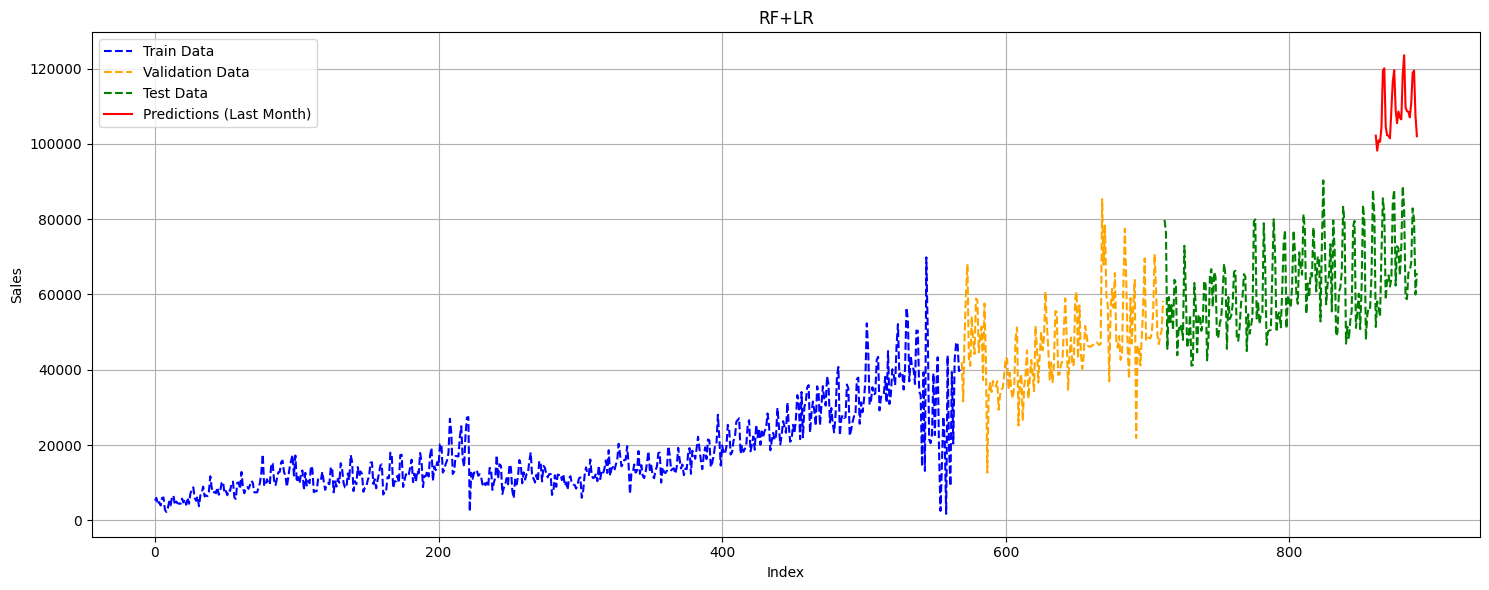

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, y_train, color='blue', label='Train Data', linestyle='--')
plt.plot(val_data.index, y_val, color='orange', label='Validation Data', linestyle='--')
plt.plot(test_data.index, y_test, color='green', label='Test Data', linestyle='--')
plt.plot(last_month_test_data.index, y_pred_last_month_combined, color='red', label='Predictions (Last Month)')
plt.title('RF+LR')
plt.xlabel('Index')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### LGBM

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'num_leaves': [15, 20, 31],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [5, 7, 9],
#     'n_estimators': [500, 1000, 2000],
#     'min_child_weight': [1e-3, 1e-2, 1e-1],
#     'bagging_fraction': [0.8, 0.9, 1.0],
#     'feature_fraction': [0.8, 0.9, 1.0]
# }

# lgbm = LGBMRegressor(random_state=42)
# grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='neg_mean_absolute_percentage_error', cv=3, verbose=1)
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_
# print("Best parameters:", best_params)

In [ ]:
lgbm = LGBMRegressor(random_state=42, n_estimators=500, verbose=-1, bagging_fraction=0.8, feature_fraction=0.8, max_depth=5, min_child_weight=0.001, num_leaves=20)

average_mape_lgbm = k_fold_cross_validation(df, features, target, lgbm, n_splits=5)
print(f"LGBM K-fold MAPE: {average_mape_lgbm}%")

LGBM K-fold MAPE: 33.28263155852711%


In [ ]:
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_val)
last_month_test_data = test_data.iloc[-30:]
y_pred_last_month_lgbm = lgbm.predict(last_month_test_data[features])
y_pred_last_month_lgbm_try = y_pred_last_month_lgbm
mape_lgbm = mean_absolute_percentage_error(last_month_test_data[target], y_pred_last_month_lgbm_try) * 100
print(f"MAPE LGBM: {mape_lgbm}%")

MAPE LGBM: 28.61668884248971%


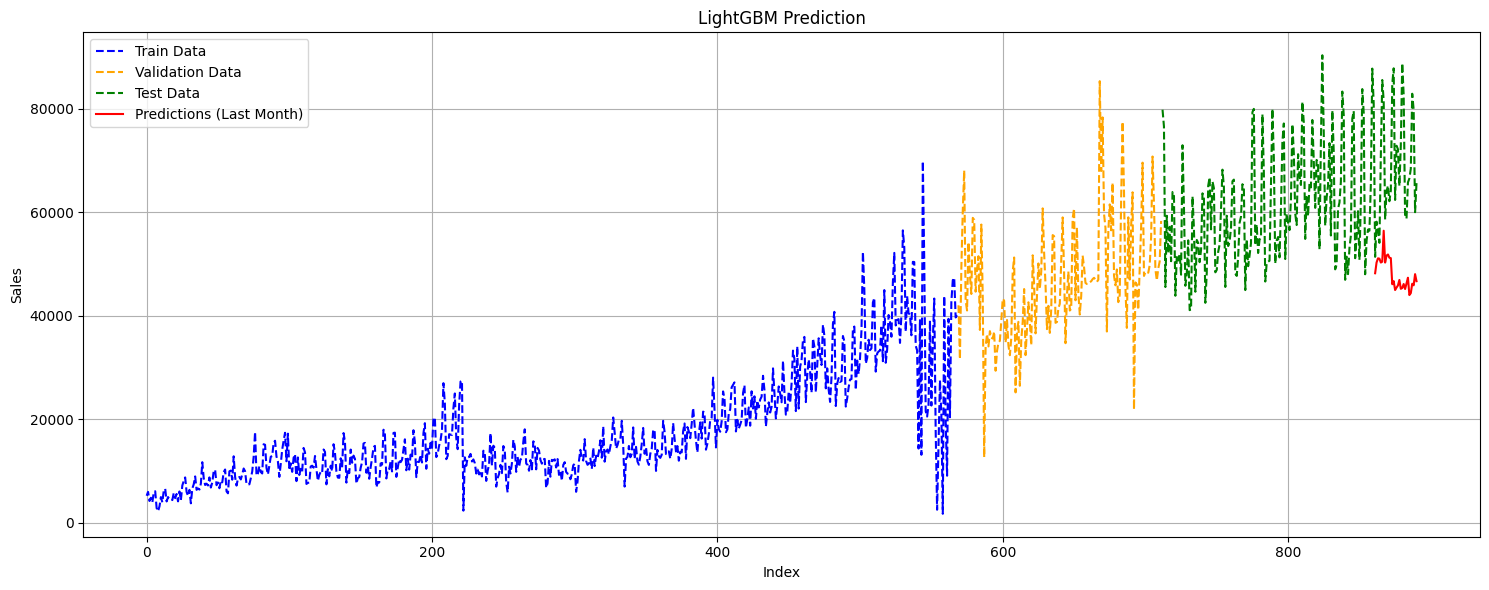

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, y_train, color='blue', label='Train Data', linestyle='--')
plt.plot(val_data.index, y_val, color='orange', label='Validation Data', linestyle='--')
plt.plot(test_data.index, y_test, color='green', label='Test Data', linestyle='--')
plt.plot(last_month_test_data.index, y_pred_last_month_lgbm_try, color='red', label='Predictions (Last Month)')
plt.title('LightGBM Prediction')
plt.xlabel('Index')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###Phophet (without holidays)

In [ ]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [ ]:
prophet_data = df[['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})

train_prophet = prophet_data.iloc[:-60]
test_prophet = prophet_data.iloc[-60:-30]
valid_prophet = prophet_data.iloc[:-30]

prophet_model = Prophet()
prophet_model.fit(train_prophet)

future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

forecast_last_month = forecast.iloc[-30:][['ds', 'yhat']]

from sklearn.metrics import mean_squared_error
mse_prophet = mean_squared_error(valid_prophet['y'], forecast_last_month['yhat'])
print(f"Prophet Model MSE for Last Month: {mse_prophet}")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_lye9hy/x2ngyig6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_lye9hy/8wvh4mns.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4914', 'data', 'file=/tmp/tmpz_lye9hy/x2ngyig6.json', 'init=/tmp/tmpz_lye9hy/8wvh4mns.json', 'output', 'file=/tmp/tmpz_lye9hy/prophet_modelatj8hgf6/prophet_model-20241213144029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:40:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:40:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Model MSE for Last Month: 119639561.33819717


In [ ]:
from sklearn.metrics import mean_squared_error
mse_prophet = mean_squared_error(test_prophet['y'], forecast_last_month['yhat'])
print(f"Prophet Model MSE for Last Month: {mse_prophet}")

Prophet Model MSE for Last Month: 119639561.33819717


In [ ]:
import itertools
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.001, 0.01, 0.1, 1],
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_range': [0.8, 0.9, 1.0],
    'n_changepoints': [10, 20, 30, 50]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the RMSEs for each params here

for params in all_params:
    m = Prophet(**params).fit(train_prophet)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mapes.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
print(tuning_results)

In [ ]:
df_cv = cross_validation(prophet_model, initial='800 days', period='180 days', horizon = '30 days')

INFO:prophet:Making 1 forecasts with cutoffs between 2023-09-01 00:00:00 and 2023-09-01 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_lye9hy/mqiaid09.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_lye9hy/sw3_tyr1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5010', 'data', 'file=/tmp/tmpz_lye9hy/mqiaid09.json', 'init=/tmp/tmpz_lye9hy/sw3_tyr1.json', 'output', 'file=/tmp/tmpz_lye9hy/prophet_modelep47canl/prophet_model-20241213143607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:36:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:36:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-09-02,75921.329607,68247.305914,83431.782805,79672.07,2023-09-01
1,2023-09-03,73641.762505,66011.650793,80910.055422,71624.77,2023-09-01
2,2023-09-04,64725.117761,57145.968927,72271.528266,48956.76,2023-09-01
3,2023-09-05,66320.039087,58992.747675,74193.780466,49831.41,2023-09-01
4,2023-09-06,67098.261609,59977.656693,74308.561695,60634.53,2023-09-01


In [ ]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,8.892581e+07,9430.048051,7178.696886,0.132442,0.047077,0.117798,0.666667
1,4 days,1.748614e+08,13223.517616,11424.659785,0.227045,0.322087,0.196366,0.333333
2,5 days,1.874319e+08,13690.578536,12906.906152,0.253192,0.322087,0.220845,0.333333
3,6 days,1.143258e+08,10692.324380,9455.801101,0.175010,0.106601,0.156331,0.666667
4,7 days,2.515481e+07,5015.456980,4655.764548,0.075273,0.087540,0.072087,1.000000


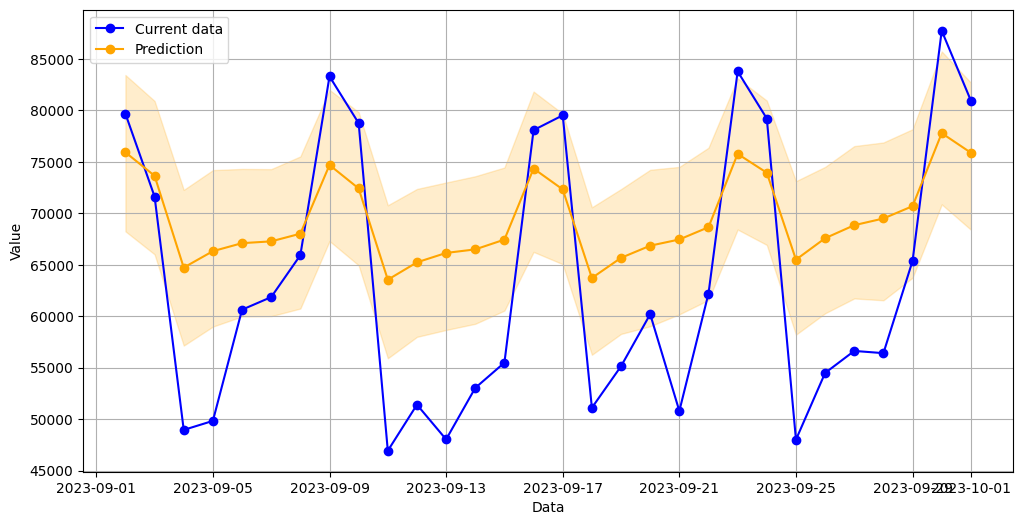

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_cv['ds'], df_cv['y'], 'o-', label='Current data', color='blue')
plt.plot(df_cv['ds'], df_cv['yhat'], 'o-', label='Prediction', color='orange')
plt.fill_between(df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'],
                 color='orange', alpha = 0.2)

plt.xlabel('Data')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

### Prophet (with holidays)

In [ ]:
prophet_data = df[['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})
prophet_data = prophet_data.sort_values('ds').reset_index(drop=True)

test_size = int(len(prophet_data) * 0.2)
valid_size = int(len(prophet_data) * 0.3)
train_data = prophet_data.iloc[:-valid_size]
test_data = prophet_data.iloc[-valid_size:-test_size]

In [ ]:
def get_df_events(res, shop):
  return res[shop][1]

In [ ]:
events = get_df_events(res, 18)

holiday_frames = []
for holiday_name, dates in events.items():
    holiday_df = pd.DataFrame({
        "holiday": holiday_name,
        "ds": pd.to_datetime(dates),
        "lower_window": 0,
        "upper_window": 0
    })
    holiday_frames.append(holiday_df)

holidays = pd.concat(holiday_frames, ignore_index=True)

In [ ]:
prophet_model_holidays = Prophet(holidays=holidays)
prophet_model_holidays.fit(train_data)

future = pd.DataFrame({'ds': test_data['ds']})

forecast_holidays = prophet_model_holidays.predict(future)

mse_test_holidays = mean_squared_error(test_data['y'], forecast_holidays['yhat'])
print(f"Prophet With Holidays - MSE Test Set: {mse_test_holidays}")

last_30_days_test = test_data.iloc[-30:]
last_30_days_forecast_holidays = forecast_holidays.iloc[-30:]
mse_last_30_days_holidays = mean_squared_error(last_30_days_test['y'], last_30_days_forecast_holidays['yhat'])
print(f"Prophet With Holidays - MSE Last 30 Days: {mse_last_30_days_holidays}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_lye9hy/wxt7wbcq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_lye9hy/8gg4_5hh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45395', 'data', 'file=/tmp/tmpz_lye9hy/wxt7wbcq.json', 'init=/tmp/tmpz_lye9hy/8gg4_5hh.json', 'output', 'file=/tmp/tmpz_lye9hy/prophet_modelfrvimjeu/prophet_model-20241213144746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:47:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:47:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet With Holidays - MSE Test Set: 68519568.95755598
Prophet With Holidays - MSE Last 30 Days: 72839693.46574903


In [ ]:
prophet_model_holidays = Prophet(holidays=holidays)
prophet_model_holidays.fit(train_data)

future = pd.DataFrame({'ds': valid_size['ds']})

forecast_holidays = prophet_model_holidays.predict(future)

mse_test_holidays = mean_squared_error(test_data['y'], forecast_holidays['yhat'])
print(f"Prophet With Holidays - MSE Test Set: {mse_test_holidays}")

last_30_days_test = test_data.iloc[-30:]
last_30_days_forecast_holidays = forecast_holidays.iloc[-30:]
mse_last_30_days_holidays = mean_squared_error(last_30_days_test['y'], last_30_days_forecast_holidays['yhat'])
print(f"Prophet With Holidays - MSE Last 30 Days: {mse_last_30_days_holidays}")

In [ ]:
df_cv_holidays = cross_validation(prophet_model_holidays, initial='680 days', period='180 days', horizon = '30 days')

INFO:prophet:Making 1 forecasts with cutoffs between 2023-04-06 00:00:00 and 2023-04-06 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_lye9hy/qqse_s_8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_lye9hy/ewnd7ue8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57745', 'data', 'file=/tmp/tmpz_lye9hy/qqse_s_8.json', 'init=/tmp/tmpz_lye9hy/ewnd7ue8.json', 'output', 'file=/tmp/tmpz_lye9hy/prophet_modelcec8k7ib/prophet_model-20241213144752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:47:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:47:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
df_p_holidays = performance_metrics(df_cv_holidays)
df_p_holidays.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,2.322193e+08,15238.744348,14231.805780,0.204149,0.192132,0.229704,0.000000
1,4 days,1.859627e+08,13636.813986,11049.735378,0.158410,0.139907,0.176670,0.333333
2,5 days,7.302312e+07,8545.356884,7654.057652,0.167083,0.139907,0.156531,0.333333
3,6 days,7.225761e+07,8500.447355,7610.885121,0.170162,0.149145,0.160109,0.333333
4,7 days,7.549600e+07,8688.843682,8110.031513,0.180180,0.149145,0.169461,0.333333


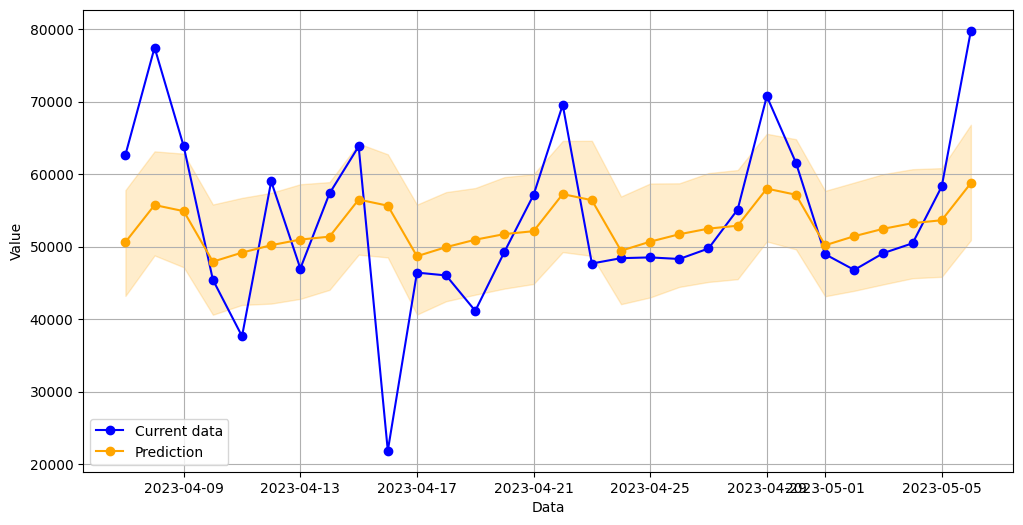

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_cv_holidays['ds'], df_cv_holidays['y'], 'o-', label='Current data', color='blue')
plt.plot(df_cv_holidays['ds'], df_cv_holidays['yhat'], 'o-', label='Prediction', color='orange')
plt.fill_between(df_cv_holidays['ds'], df_cv_holidays['yhat_lower'], df_cv_holidays['yhat_upper'],
                 color='orange', alpha=0.2)

plt.xlabel('Data')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()